In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
from ephys_queries import db_setup_core, select_spike_times, select_discrete_data
from dotenv import load_dotenv

In [2]:
data_dir = Path(".").absolute().parent / "data"
fig_dir = Path(".").absolute().parent / "figs"

In [3]:
df = (
    pd.read_csv(data_dir / "baseline.csv")
    .loc[lambda x: 
         (x["group_name"].isin((
            "chronic_saline", 
            "citalopram_continuation", 
                ))
        ) & (
         x["cluster"] != "no_baseline")]
)

In [4]:
df_response = (pd.read_csv(data_dir / "baseshock_responses.csv"))

In [13]:
group_names = (
            "chronic_saline", 
            "citalopram_continuation", 
                )
block_name = "base_shock"
t_before=300
fs = 30000

load_dotenv()
engine, metadata = db_setup_core()

In [56]:
session_names = df["session_name"].unique()
session = np.random.choice(session_names, 1)[0]

(
    df[["neuron_id", "session_name","cluster"]]
    .groupby(['session_name', "cluster"])
    .apply(len)
    .reset_index()
    .loc[lambda x: x["session_name"]==session]
)

,session_name,cluster,0
15,hamilton_19,fast_firing,6
16,hamilton_19,slow_irregular,19
17,hamilton_19,slow_regular,26


In [57]:
# session = "hamilton_13"

In [58]:
block_name

'base_shock'

In [59]:
df_spikes = (
    select_spike_times(
        engine, metadata, 
        block_name=block_name, 
        group_names=group_names,
        session_names=[session]
    )
    .assign(
        spiketimes= lambda x: x["spike_time_samples"].divide(fs)
    )
)
df_events = (
    select_discrete_data(
        engine, metadata, 
        block_name=block_name,
        group_names=group_names,
    )
    .loc[lambda x: x["session_name"]==session]
    .assign(
        event_s= lambda x: x["timepoint_sample"].divide(fs)
    )
)

In [60]:
df_spikes = df_spikes.merge(df_response[["response_baseshock", "neuron_id"]])

In [61]:
stims

[array([1793.75666667, 1793.8372    , 1793.91186667, ..., 2400.10443333,
        2400.14923333, 2400.16883333]),
 array([1793.90826667, 1793.98986667, 1794.12283333, ..., 2399.63646667,
        2400.1873    , 2400.1875    ]),
 array([1793.7076    , 1793.85273333, 1794.1415    , ..., 2397.9638    ,
        2399.15156667, 2399.92006667]),
 array([1793.99916667, 1794.15326667, 1794.97746667, ..., 2399.7638    ,
        2399.80506667, 2400.1666    ])]

In [62]:
from spiketimes.df.conversion import df_to_list


_, inhibs = df_to_list(df_spikes[df_spikes["response_baseshock"] == "Inhibited"],
               spiketimes_col="spiketimes",
               spiketrain_col="neuron_id")

_, stims = df_to_list(df_spikes[df_spikes["response_baseshock"] == "Stimulated"],
               spiketimes_col="spiketimes",
               spiketrain_col="neuron_id")

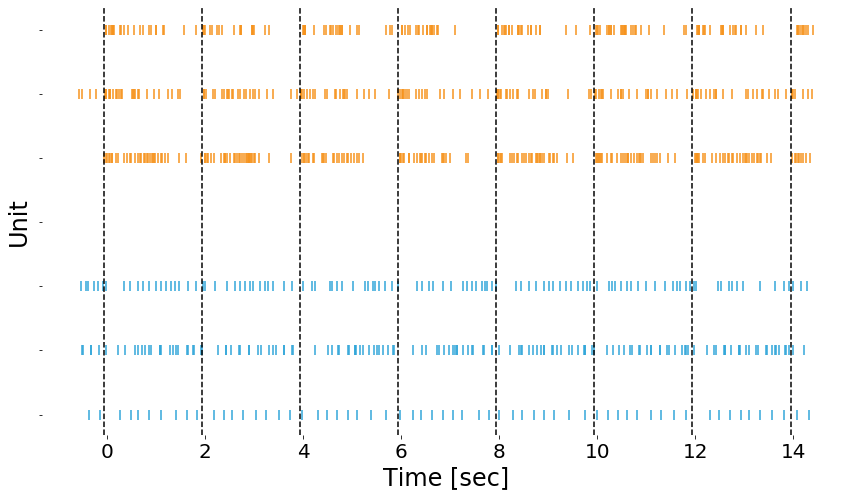

In [87]:
from spiketimes.plots import grouped_raster, add_event_vlines
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(12, 7))

t_start = 1921.4
t_stop = t_start + 15

events = (
    df_events[
        (df_events["event_s"] >= t_start) & (df_events["event_s"] <= t_stop)]
    ["event_s"].values
)

ax = grouped_raster([inhibs[1::5], stims[2::5]],
                    ["#31A6D9", "#F6931D"],
               t_start=t_start, t_stop=t_stop,
                    space_between_groups=1,
               plot_kwargs={"s":90},
                   ax=ax)

ax.set_yticklabels([])

ax.set_xticks(ticks=np.round(events))
ax.set_xticklabels([0, 2, 4, 6, 8, 10, 12, 14], fontsize=20)


ax.set(frame_on=False)

ax.set_ylabel("Unit", fontsize=24)
ax.set_xlabel("Time [sec]", fontsize=24)

add_event_vlines(ax, events)

plt.tight_layout()
plt.savefig(fig_dir / "psth_raster.png", transparent=True, dpi=300)

In [43]:
inhibs

[]

In [44]:
stims

[]